In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader
import os
import sys
import time

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim

from sklearn.metrics import accuracy_score

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Preprocess data

In [2]:
# word2vec

# download the word2vec-google-news-300
w2v = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
train_set = pd.read_csv('train_set_modified.csv')
dev_set = pd.read_csv('dev_set.csv')
test_set = pd.read_csv('test.csv')

train_set.head()

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?


In [4]:
# select four classes: 0, 1, 2, 3
# 4 and 5 will be OTHERS (4)

# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4


In [5]:
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    # handle empty string after removing stop words
    if not len(filtered_sentence):
        filtered_sentence = sentence

    token = word_tokenize(filtered_sentence)
    return token

In [11]:
train_set['cleaned_text'] = train_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [12]:
max_length = train_set['cleaned_text'].str.len().max()

# get the embedding shape of the model
embed_shape = len(w2v['test'])
padded_sentences = []

for index, row in train_set.iterrows():

    sentence = row['cleaned_text']

    # get word embedding of each word
    word_embeddings = []

    for word in sentence:
        # check if the word is present in the model
        if word in w2v.key_to_index:
            word_embeddings.append(w2v[word])
        else:
             word_embeddings.append(np.zeros(shape=(embed_shape)))

    # pad sentences to max_length
    pad_width = max_length - len(sentence)

    padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
    padded_sentences.append(padded_sentence)
    # print(padded_sentence.shape) # max_length x 300

train_set['vector'] = padded_sentences

train_set.head()


,label-coarse,label-fine,text,cleaned_text,vector
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [13]:
def preprocess_x(dataset):
  dataset['cleaned_text'] = dataset['text'].apply(token)
  max_length = dataset['cleaned_text'].str.len().max()

  # get the embedding shape of the model
  embed_shape = len(w2v['test'])
  padded_sentences = []

  for index, row in dataset.iterrows():

      sentence = row['cleaned_text']

      # get word embedding of each word
      word_embeddings = []

      for word in sentence:
          # check if the word is present in the model
          if word in w2v.key_to_index:
              word_embeddings.append(w2v[word])
          else:
              word_embeddings.append(np.zeros(shape=(embed_shape)))

      # pad sentences to max_length
      pad_width = max_length - len(sentence)

      padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
      padded_sentences.append(padded_sentence)

  x = torch.tensor(np.array(padded_sentences))

  return x

In [14]:
def encode_y_label(df, num_classes): # one hot encoding
  encoded_labels = df['label-coarse'].apply(lambda label: list(np.eye(num_classes)[label]))
  df['encoded-coarse-label'] = encoded_labels
  return df

train_set = encode_y_label(train_set, 5)
dev_set = encode_y_label(dev_set, 5)
test_set = encode_y_label(test_set, 5)

In [15]:
# split into X and y
X_train = preprocess_x(train_set)
y_train = train_set['encoded-coarse-label']

X_dev = preprocess_x(dev_set)
y_dev = dev_set['encoded-coarse-label']

X_test = preprocess_x(test_set)
y_test = test_set['encoded-coarse-label']

# mini-batch strategy
batch_size = 32

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float64)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
dev_data = CustomDataset(X_dev, y_dev)
test_data = CustomDataset(X_test, y_test)

<ipython-input-15-8da521b9289c>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float64)


In [16]:
# model

class WordRNNGRU(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers = 1):
        super(WordRNNGRU, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dense = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        encoding, _ = self.rnn(x)

        pooled_output = F.max_pool2d(encoding, kernel_size=(encoding.size(1), 1), stride=(encoding.size(1), 1))

        output = self.dense(pooled_output)

        logits = self.softmax(output)
        return logits


seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

In [17]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [18]:
input_dim = 300
hidden_dim = 128
output_dim = 5
model = WordRNNGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [19]:
num_epochs = 100
best_accuracy = 0.0
max_patience = 5
current_patience = 0
dev_accuracy_list = []
run_time = []

train_loader = DataLoader(train_data, batch_size=24, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=24, shuffle=True)

for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0
  start_time_epoch = time.time()

  for x_batch, y_batch in train_loader:
    outputs = model(x_batch.float()) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(1), y_batch)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

  average_loss = total_training_loss / len(train_loader)
  print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs

      # forward pass
      y_pred = model(x_batch.float())
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      y_batch = torch.argmax(y_batch, dim=1)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  dev_accuracy_list.append(accuracy)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
  else:
    current_patience += 1
    if current_patience >= max_patience:
        print(f"Early stopping after {epoch} epochs.")
        end_time_epoch = time.time()
        time_taken = end_time_epoch - start_time_epoch
        run_time.append(time_taken)
        total_time_taken = sum(run_time)
        print(f"Time taken to run the model with optimal parameters: {total_time_taken} seconds ")
        break

  end_time_epoch = time.time()
  time_taken = end_time_epoch - start_time_epoch
  run_time.append(time_taken)


Epoch: 0, training set loss: 1.42542
Epoch: 0, dev set loss: 1.26748
Accuracy: 65.00%
Epoch: 1, training set loss: 1.23380
Epoch: 1, dev set loss: 1.20356
Accuracy: 70.20%
Epoch: 2, training set loss: 1.17825
Epoch: 2, dev set loss: 1.16427
Accuracy: 74.40%
Epoch: 3, training set loss: 1.14624
Epoch: 3, dev set loss: 1.13927
Accuracy: 76.40%
Epoch: 4, training set loss: 1.12021
Epoch: 4, dev set loss: 1.13134
Accuracy: 77.80%
Epoch: 5, training set loss: 1.10739
Epoch: 5, dev set loss: 1.15129
Accuracy: 75.20%
Epoch: 6, training set loss: 1.09197
Epoch: 6, dev set loss: 1.12145
Accuracy: 78.60%
Epoch: 7, training set loss: 1.07936
Epoch: 7, dev set loss: 1.12793
Accuracy: 76.80%
Epoch: 8, training set loss: 1.06917
Epoch: 8, dev set loss: 1.11353
Accuracy: 78.80%
Epoch: 9, training set loss: 1.05626
Epoch: 9, dev set loss: 1.10762
Accuracy: 80.00%
Epoch: 10, training set loss: 1.04781
Epoch: 10, dev set loss: 1.12079
Accuracy: 78.20%
Epoch: 11, training set loss: 1.04344
Epoch: 11, dev

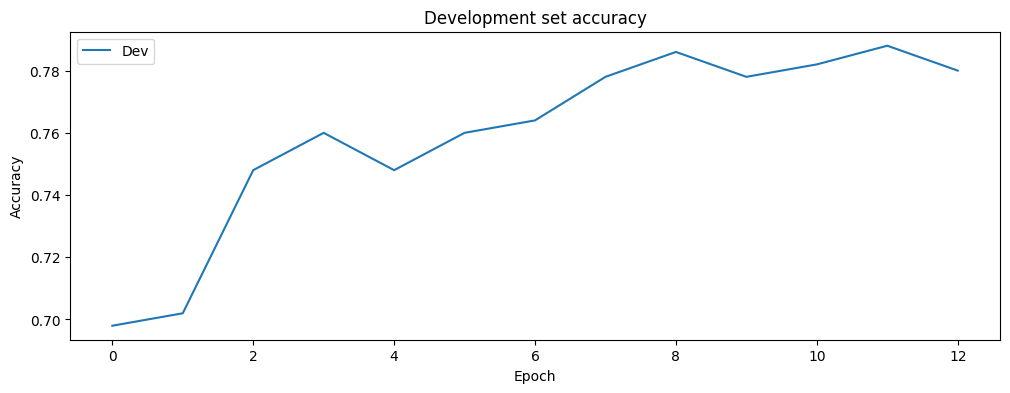

In [ ]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('Development set accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Find optimal batch size

In [ ]:
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_sizes = [2, 4, 8, 16, 24, 32, 64, 128, 256, 512]
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [ ]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_batch_size = {}
time_taken_batch_size = {}
loss_batch_size = {}

for batch_size in batch_sizes:
  model = WordRNNGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break

  end_time = time.time()
  time_taken_batch_size[batch_size] =  end_time - start_time
  accuracy_list_batch_size[batch_size] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_batch_size[batch_size] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.29748
Epoch: 0, dev set loss: 1.18845
Accuracy: 71.80%
Epoch: 1, training set loss: 1.16587
Epoch: 1, dev set loss: 1.14800
Accuracy: 76.20%
Epoch: 2, training set loss: 1.12134
Epoch: 2, dev set loss: 1.12996
Accuracy: 76.80%
Epoch: 3, training set loss: 1.09061
Epoch: 3, dev set loss: 1.12969
Accuracy: 77.20%
Epoch: 4, training set loss: 1.06717
Epoch: 4, dev set loss: 1.11146
Accuracy: 79.00%
Epoch: 5, training set loss: 1.05211
Epoch: 5, dev set loss: 1.11636
Accuracy: 78.40%
Epoch: 6, training set loss: 1.03910
Epoch: 6, dev set loss: 1.11595
Accuracy: 78.20%
Epoch: 7, training set loss: 1.02940
Epoch: 7, dev set loss: 1.11042
Accuracy: 79.00%
Epoch: 8, training set loss: 1.01774
Epoch: 8, dev set loss: 1.11152
Accuracy: 79.00%
Epoch: 9, training set loss: 1.01253
Epoch: 9, dev set loss: 1.10969
Accuracy: 78.80%
Epoch: 10, training set loss: 1.00808
Epoch: 10, dev set loss: 1.09584
Accuracy: 80.20%
Epoch: 11, training set loss: 1.00683
Epoch: 11, dev

In [ ]:
accuracy_list_batch_size

{2: 0.7833,
 4: 0.7805000000000001,
 8: 0.7916000000000001,
 16: 0.7699999999999999,
 24: 0.7656000000000002,
 32: 0.7595000000000001,
 64: 0.7402000000000003,
 128: 0.7268000000000001,
 256: 0.6910000000000001,
 512: 0.6256}

Text(0.5, 1.0, 'Accuracy against Batch size')

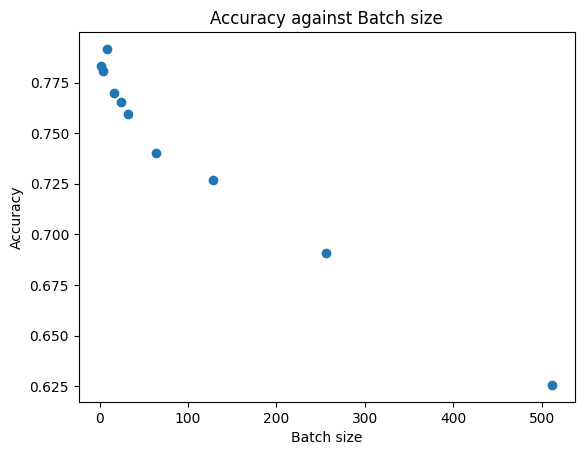

In [ ]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_batch_size.keys(), accuracy_list_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Accuracy against Batch size")

Text(0.5, 1.0, 'Time taken against Batch size')

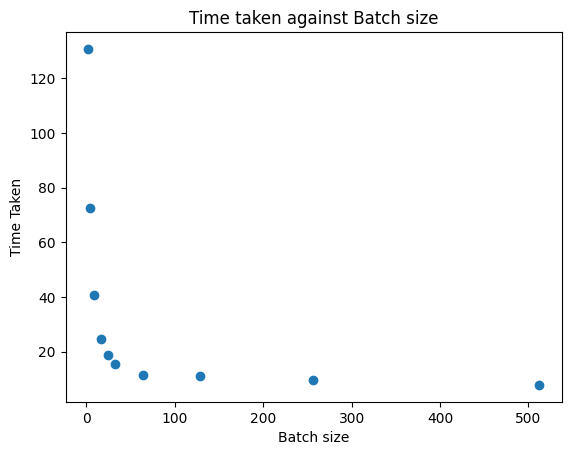

In [ ]:
# Plot dev time against batch size
plt.scatter(time_taken_batch_size.keys(), time_taken_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Time Taken")
plt.title("Time taken against Batch size")

Batch size 16 is chosen.

## Find optimal number of hidden layers

In [ ]:
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_size = 16
num_layers = [1, 2, 3, 4, 5, 6]
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_num_layers = {}
time_taken_num_layers = {}
loss_num_layers = {}

for layer in num_layers:
  model = WordRNNGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers= layer)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break

  end_time = time.time()
  time_taken_num_layers[layer] =  end_time - start_time
  accuracy_list_num_layers[layer] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_num_layers[layer] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.39806
Epoch: 0, dev set loss: 1.23414
Accuracy: 68.80%
Epoch: 1, training set loss: 1.21194
Epoch: 1, dev set loss: 1.17168
Accuracy: 74.60%
Epoch: 2, training set loss: 1.15992
Epoch: 2, dev set loss: 1.15853
Accuracy: 74.00%
Epoch: 3, training set loss: 1.13427
Epoch: 3, dev set loss: 1.14007
Accuracy: 75.00%
Epoch: 4, training set loss: 1.11090
Epoch: 4, dev set loss: 1.12487
Accuracy: 78.00%
Epoch: 5, training set loss: 1.09283
Epoch: 5, dev set loss: 1.12223
Accuracy: 77.20%
Epoch: 6, training set loss: 1.08169
Epoch: 6, dev set loss: 1.11163
Accuracy: 78.40%
Epoch: 7, training set loss: 1.06498
Epoch: 7, dev set loss: 1.11025
Accuracy: 78.40%
Epoch: 8, training set loss: 1.05308
Epoch: 8, dev set loss: 1.12277
Accuracy: 79.60%
Epoch: 9, training set loss: 1.04767
Epoch: 9, dev set loss: 1.11409
Accuracy: 79.20%
Epoch: 10, training set loss: 1.03806
Epoch: 10, dev set loss: 1.09712
Accuracy: 80.60%
Epoch: 11, training set loss: 1.03044
Epoch: 11, dev

In [ ]:
accuracy_list_num_layers

{1: 0.7805,
 2: 0.7696,
 3: 0.7428000000000001,
 4: 0.6491,
 5: 0.3954000000000001,
 6: 0.34330000000000005}

Text(0.5, 1.0, 'Accuracy against Number of Layers')

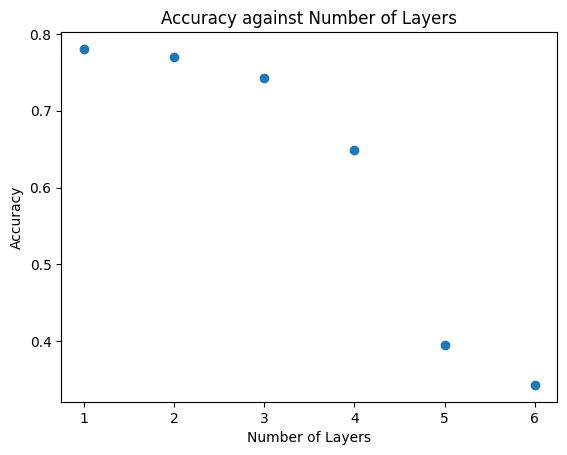

In [ ]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_num_layers.keys(), accuracy_list_num_layers.values())
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Layers")

Text(0.5, 1.0, 'Time taken against Number of Layers')

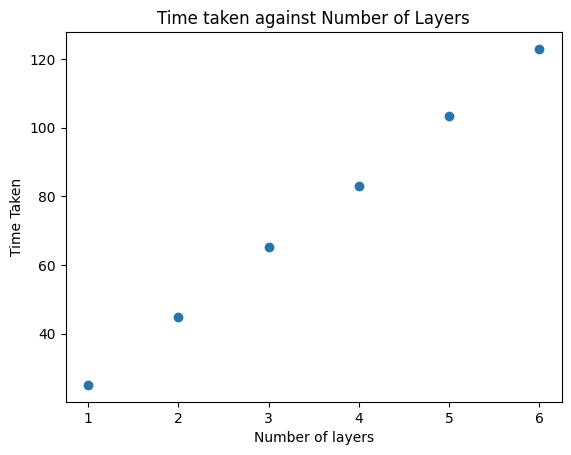

In [ ]:
# Plot dev time against batch size
plt.scatter(time_taken_num_layers.keys(), time_taken_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Layers")

1 is chosen for highest accuracy and shortest running time.

## Find optimal number of hidden neurons

In [ ]:
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_size = 16
hidden_dims = [64, 138, 256, 512]
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [ ]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_hidden_dims = {}
time_taken_hidden_dims = {}
loss_hidden_dims = {}

for hidden_dim in hidden_dims:
  model = WordRNNGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break

  end_time = time.time()
  time_taken_hidden_dims[hidden_dim] =  end_time - start_time
  accuracy_list_hidden_dims[hidden_dim] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_hidden_dims[hidden_dim] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.43972
Epoch: 0, dev set loss: 1.30293
Accuracy: 58.80%
Epoch: 1, training set loss: 1.25487
Epoch: 1, dev set loss: 1.20087
Accuracy: 72.40%
Epoch: 2, training set loss: 1.18571
Epoch: 2, dev set loss: 1.16235
Accuracy: 75.20%
Epoch: 3, training set loss: 1.15143
Epoch: 3, dev set loss: 1.14395
Accuracy: 77.20%
Epoch: 4, training set loss: 1.12800
Epoch: 4, dev set loss: 1.15404
Accuracy: 75.60%
Epoch: 5, training set loss: 1.10974
Epoch: 5, dev set loss: 1.14327
Accuracy: 75.40%
Epoch: 6, training set loss: 1.09729
Epoch: 6, dev set loss: 1.13851
Accuracy: 75.80%
Epoch: 7, training set loss: 1.08349
Epoch: 7, dev set loss: 1.13664
Accuracy: 76.80%
Epoch: 8, training set loss: 1.07477
Epoch: 8, dev set loss: 1.13927
Accuracy: 76.40%
Epoch: 9, training set loss: 1.06632
Epoch: 9, dev set loss: 1.12904
Accuracy: 76.40%
Epoch: 10, training set loss: 1.05813
Epoch: 10, dev set loss: 1.12806
Accuracy: 76.00%
Epoch: 11, training set loss: 1.05322
Epoch: 11, dev

In [ ]:
accuracy_list_hidden_dims

{64: 0.7602000000000001,
 138: 0.7716000000000001,
 256: 0.7789,
 512: 0.7766000000000001}

Text(0.5, 1.0, 'Accuracy against Number of Hidden Neurons')

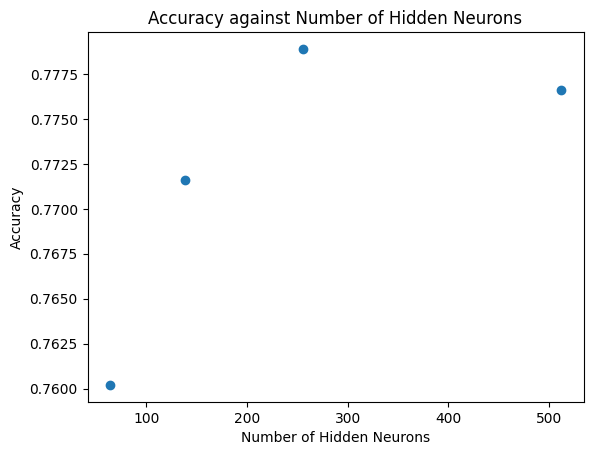

In [ ]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_hidden_dims.keys(), accuracy_list_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Hidden Neurons")

Text(0.5, 1.0, 'Time taken against Number of Hidden Neurons')

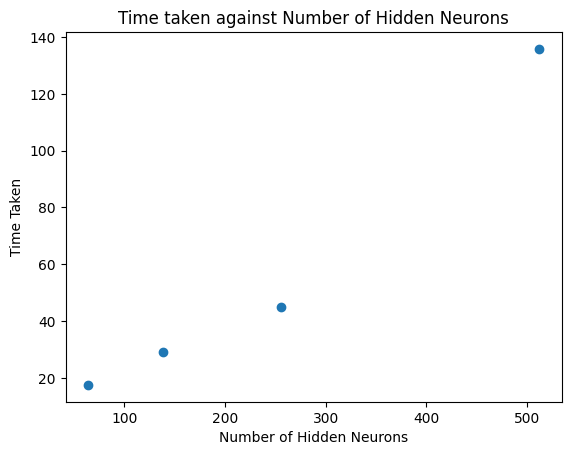

In [ ]:
# Plot dev time against batch size
plt.scatter(time_taken_hidden_dims.keys(), time_taken_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Hidden Neurons")

256 is chosen for higher accuracy.

## Final training


In [29]:
input_dim = 300
hidden_dim = 256
output_dim = 5
batch_size = 16
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

model = WordRNNGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [30]:
num_epochs = 100
best_accuracy = 0.0
max_patience = 5
current_patience = 0
train_loss_list = []
train_accuracy_list = []
dev_loss_list = []
dev_accuracy_list = []
run_time = []

for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0
  start_time_epoch = time.time()

  train_true_labels = []
  train_predicted_labels = []

  for x_batch, y_batch in train_loader:
    outputs = model(x_batch.float()) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(1), y_batch)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

    predicted_train_labels = torch.argmax(outputs.squeeze(1), dim=1)
    y_batch = torch.argmax(y_batch, dim=1)

    train_true_labels.extend(y_batch.tolist())
    train_predicted_labels.extend(predicted_train_labels.tolist())

  average_loss = total_training_loss / len(train_loader)
  print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))
  train_loss_list.append(average_loss)

  train_accuracy = calculate_accuracy(torch.tensor(train_true_labels), torch.tensor(train_predicted_labels))
  train_accuracy_list.append(train_accuracy)

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs

      # forward pass
      y_pred = model(x_batch.float())
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      y_batch = torch.argmax(y_batch, dim=1)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))
    dev_loss_list.append(average_dev_loss)

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  dev_accuracy_list.append(accuracy)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
  else:
    current_patience += 1
    if current_patience >= max_patience:
        print(f"Early stopping after {epoch} epochs.")
        end_time_epoch = time.time()
        time_taken = end_time_epoch - start_time_epoch
        run_time.append(time_taken)
        total_time_taken = sum(run_time)
        print(f"Time taken to run the model with optimal parameters: {total_time_taken} seconds ")
        break
  end_time_epoch = time.time()
  time_taken = end_time_epoch - start_time_epoch
  run_time.append(time_taken)


Epoch: 0, training set loss: 1.40165
Epoch: 0, dev set loss: 1.22204
Accuracy: 70.40%
Epoch: 1, training set loss: 1.20994
Epoch: 1, dev set loss: 1.16657
Accuracy: 74.40%
Epoch: 2, training set loss: 1.15898
Epoch: 2, dev set loss: 1.15621
Accuracy: 75.40%
Epoch: 3, training set loss: 1.13025
Epoch: 3, dev set loss: 1.13646
Accuracy: 76.00%
Epoch: 4, training set loss: 1.10423
Epoch: 4, dev set loss: 1.13404
Accuracy: 77.20%
Epoch: 5, training set loss: 1.08379
Epoch: 5, dev set loss: 1.12886
Accuracy: 77.20%
Epoch: 6, training set loss: 1.07270
Epoch: 6, dev set loss: 1.12804
Accuracy: 77.20%
Epoch: 7, training set loss: 1.06118
Epoch: 7, dev set loss: 1.12715
Accuracy: 77.20%
Epoch: 8, training set loss: 1.05519
Epoch: 8, dev set loss: 1.12835
Accuracy: 77.60%
Epoch: 9, training set loss: 1.04882
Epoch: 9, dev set loss: 1.11898
Accuracy: 78.00%
Epoch: 10, training set loss: 1.03423
Epoch: 10, dev set loss: 1.11174
Accuracy: 78.80%
Epoch: 11, training set loss: 1.02550
Epoch: 11, dev

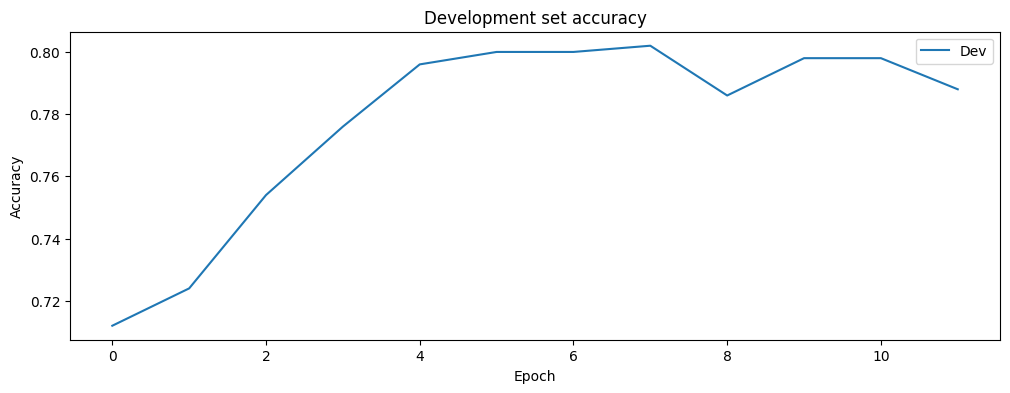

In [ ]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('Development set accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### Using test set

In [ ]:
print(x_batch, y_batch)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 1.1523e-01,  2.3340e-01, -1.3184e-01,  ..., -3.1836e-01,
           2.7344e-01, -6.9275e-03],
         [ 2.0898e-01,  6.7383e-02, -4.2236e-02,  ...,  8.9355e-02,
           2.6562e-01, -1.6211e-01],
         [-6.3965e-02,  6.8359e-02,  2.2461e-01,  ...,  5.7861e-02,
           1.5918e-01, -6.2012e-02]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-1.3489e-02, -1

In [33]:
model.eval()
with torch.no_grad():
  all_true_labels = []
  all_predicted_labels = []
  total_test_loss = 0

  test_loader = DataLoader(test_data, shuffle=True)

  for X, y in test_loader:
    # forward pass
    y_pred = model(X.float())
    loss = criterion(y_pred.squeeze(1), y)

    total_test_loss += loss.item()

    predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

    y_batch = torch.argmax(y, dim=1)

    all_true_labels.extend(y_batch.tolist())
    all_predicted_labels.extend(predicted_labels.tolist())

  average_test_loss = total_test_loss
  print(f"Average loss: {average_test_loss}")

accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
print(f"Accuracy: {accuracy * 100:.2f}%")

Average loss: 556.9489002227783
Accuracy: 79.60%


In [34]:
result_df = pd.DataFrame({"train_loss":train_loss_list,
                "train_accuracy":train_accuracy_list,
                "dev_loss":dev_loss_list,
                "dev_accuracy":dev_accuracy_list,
                "epoch_time":time_taken})
display(result_df)


,train_loss,train_accuracy,dev_loss,dev_accuracy,epoch_time
0,1.401647,0.498183,1.222043,0.704,8.12484
1,1.209940,0.704766,1.166573,0.744,8.12484
2,1.158977,0.750404,1.156213,0.754,8.12484
3,1.130247,0.783118,1.136463,0.760,8.12484
4,1.104226,0.807149,1.134038,0.772,8.12484
5,1.083792,0.828756,1.128862,0.772,8.12484
6,1.072699,0.840267,1.128043,0.772,8.12484
7,1.061178,0.848748,1.127151,0.772,8.12484
8,1.055191,0.855210,1.128351,0.776,8.12484
9,1.048823,0.862278,1.118982,0.780,8.12484
